## Naive Bayes Model

Train a Naive Bayes model on the [Sentiment Analysis on Movie Reviews](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data). The dataset contains 15,000 movie reviews. Your task is to train a Naive Bayes model on the training set and predict the labels of the test set. 

### Data

The dataset contains movie reviews from Rotten Tomatoes. Each review is labeled as follows:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

In addition to the entire review, the reviews are split into phrases and each phrase is labeled. The entire review is assigned a `SentenceID` and each phrase is assigned a `PhraseID`. The phrases were produced by the Stanford Parser (stanza). 

## Section 0: Load the data

In [1]:
import pandas as pd
import numpy as np

train_url = 'https://raw.githubusercontent.com/JamesMTucker/DATA_340_NLP/master/assignment_notebooks/data/nb_train.tsv'
test_url = 'https://raw.githubusercontent.com/JamesMTucker/DATA_340_NLP/master/assignment_notebooks/data/nb_test.tsv'

train_df = pd.read_csv(train_url, sep='\t')
test_df = pd.read_csv(test_url, sep='\t')

In [2]:
## train data
train_df.head(20)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [3]:
train_df.shape

(156060, 4)

In [4]:
## test data
test_df.head(20)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [5]:
test_df.shape

(66292, 3)

## Section 1: Data Exploration
Consider:
* has the data been preprocessed already?
* How many reviews are in the dataset?
* How many phrases are in the dataset?
* What is the distribution of the labels? (i.e. how many reviews are negative, neutral, positive)
* What is the distribution of the labels for each phrase? (i.e. how many phrases are negative, neutral, positive)
* What is the distribution of the words/tokens in the dataset?
* How many unique words are in the dataset?

In [6]:
# Unique reviews
# in the training set - 8529
len(train_df['SentenceId'].unique())
# in the test set - 3310
len(test_df['SentenceId'].unique())

3310

In [7]:
# phrases in training set
len(train_df.PhraseId.unique())

156060

In [8]:
# number of entries per review
train_df['SentenceId'].value_counts()

1       63
5555    63
509     59
625     58
403     57
        ..
7572     1
4579     1
2392     1
2429     1
4982     1
Name: SentenceId, Length: 8529, dtype: int64

In [9]:
# View all entries for the first review
train_df.iloc[0:63]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
58,59,1,much,2
59,60,1,of a story,2
60,61,1,a story,2
61,62,1,story,2


In [10]:
# First phrase
train_df.loc[0,'Phrase']

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [11]:
# determine sentiment label distribution
train_df.Sentiment.value_counts()

df = train_df.Sentiment.value_counts().rename_axis('unique_values').reset_index(name='counts')
df['unique_values'].astype(str)
df

,unique_values,counts
0,2,79582
1,3,32927
2,1,27273
3,4,9206
4,0,7072


In [12]:
!pip install seaborn

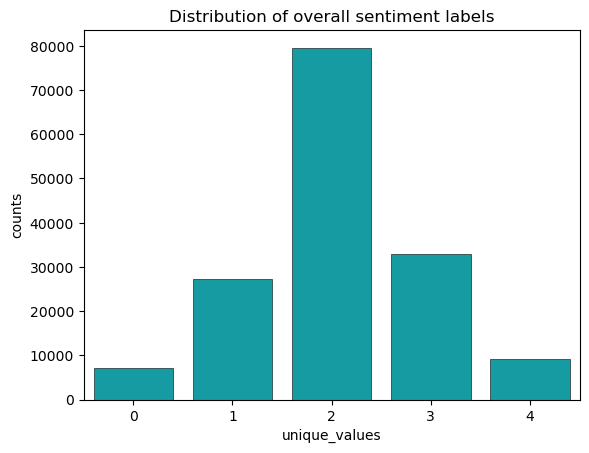

In [13]:
import seaborn as sns
# Plot sentiment label distribution
fig = sns.barplot(data=df, x='unique_values', y='counts', color='#00B0BA', edgecolor='k', linewidth=0.4
                  ).set(title='Distribution of overall sentiment labels')

## Section 2: Data Preprocessing

In the following section, please preprocess the data. How you preprocess the data will align with what features you are engineering for your model. This might include: tokenization, lemmatization, stemming, removing stopwords, etc. You should also consider how you will handle the labels. You might consider the following: one-hot encoding, label encoding, etc.

In [14]:
# subset train, test, validate datasets by full reviews
train_df = train_df.drop_duplicates(subset=["SentenceId"], keep="first")
train_df.shape

(8529, 4)

In [15]:
# subset train, test, validate datasets by full reviews
test_df = test_df.drop_duplicates(subset=["SentenceId"], keep="first")
test_df.shape

(3310, 3)

In [16]:
!pip install nltk

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
!pip install spacy download en_core_web_lg
!pip install spacy download en_core_web_sm

ERROR: Could not find a version that satisfies the requirement en_core_web_lg (from versions: none)
ERROR: No matching distribution found for en_core_web_lg


In [19]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0.tar.gz

     --------------------------------------- 12.8/12.8 MB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


In [259]:
# define function for removing stopwords, tokenization, removing punctuation
import string
import spacy
from nltk.corpus import stopwords

def preprocess(text: str) -> str:
    """remove stopwords, tokenize, remove punctuation"""
    # import dependencies
    NLP = spacy.load('en_core_web_sm')
    # stopwords 
    stop_words = set(stopwords.words('english'))
    # punctuation
    punctuation = list(string.punctuation)
    # tokenize the text with spacy
    doc = NLP(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_ not in stop_words and token.lemma not in punctuation]
    return " ".join(tokens)

In [21]:
# preprocess train and test sets
from tqdm import tqdm
tqdm.pandas()

train_df = train_df.copy()
train_df['Phrase'] = train_df['Phrase'].progress_apply(preprocess)
train_df.head()

100%|████████████████████████████████████████████████████████████████████████████| 8529/8529 [1:12:31<00:00,  1.96it/s]


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapade demonstrate adage good goose a...,1
63,64,2,quiet introspective entertain independent wort...,4
81,82,3,even fan ismail merchant work i suspect would ...,1
116,117,4,positively thrilling combination ethnography i...,3
156,157,5,aggressive self glorification manipulative whi...,1


In [22]:
test_df = test_df.copy()
test_df['Phrase'] = test_df['Phrase'].progress_apply(preprocess)
test_df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 3310/3310 [27:49<00:00,  1.98it/s]


,PhraseId,SentenceId,Phrase
0,156061,8545,intermittently pleasing mostly routine effort
15,156076,8546,kidman really thing worth watch birthday girl ...
93,156154,8547,get rhythm movie become heady experience
117,156178,8548,i keep wish i watch documentary wartime navajo...
158,156219,8549,kinnear aim sympathy rather deliver performanc...


In [53]:
train_df

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapade demonstrate adage good goose a...,1
63,64,2,quiet introspective entertain independent wort...,4
81,82,3,even fan ismail merchant work i suspect would ...,1
116,117,4,positively thrilling combination ethnography i...,3
156,157,5,aggressive self glorification manipulative whi...,1
...,...,...,...,...
155984,155985,8540,either willing go claustrophobic concept,2
155997,155998,8541,despite annoyance capable clayburgh tambor rea...,2
156021,156022,8542,try parody genre already joke united states,1
156031,156032,8543,movie downfall substitute plot personality,1


## Section 3: Feature Engineering

In this section, you should engineer features for your model. You could consider the following: bag of words, tf-idf, brown tags.

In [23]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [271]:
# split train data into train + validation sets
# validation set is 20% of train data

X_train, X_test, y_train, y_test = train_test_split(train_df['Phrase'], train_df['Sentiment'], test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(6823, 1706, 6823, 1706)

In [237]:
# read clean data into notebook -- for modeling without text preprocessing 

train_df_1 = pd.read_csv(train_url, sep='\t')
test_df_1 = pd.read_csv(test_url, sep='\t')

train_df_1 = train_df_1.drop_duplicates(subset=["SentenceId"], keep="first")
test_df_1 = test_df_1.drop_duplicates(subset=["SentenceId"], keep="first")

# TTS uncleaned data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(train_df_1['Phrase'], train_df_1['Sentiment'], test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(6823, 1706, 6823, 1706)

In [272]:
### tf-idf
# instantiate TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer 
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

In [239]:
# fit tf-idf vectorizer to uncleaned data
X_train_vectors_1 = vectorizer.fit_transform(X_train_1)
X_test_vectors_1 = vectorizer.transform(X_test_1)

In [117]:
X_train_vectors

<6823x11191 sparse matrix of type '<class 'numpy.float64'>'
	with 63223 stored elements in Compressed Sparse Row format>

In [118]:
X_test_vectors

<1706x11191 sparse matrix of type '<class 'numpy.float64'>'
	with 14327 stored elements in Compressed Sparse Row format>

## Section 4: Model Training

In this section, you should engineer at least two models. You should train each model on the training set and evaluate the performance of each model on the test set. You should also compare the performance of each model. You should also explain the performance of each model.

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn import metrics
from sklearn.metrics import classification_report

### Model 1: Multinomial Naive Bayes (full reviews)

In [130]:
# Train a Naive Bayes classifier
nb = MultinomialNB()

# Fit the classifier on the training data
nb.fit(X_train_vectors, y_train)

MultinomialNB()

In [132]:
# Make predictions on the test data
y_pred = nb.predict(X_test_vectors)

In [133]:
# Calculate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.40


In [134]:
# vectorize test data
test_vectors = vectorizer.transform(test_df['Phrase'])
test_vectors

<3310x11191 sparse matrix of type '<class 'numpy.float64'>'
	with 28316 stored elements in Compressed Sparse Row format>

In [138]:
# run on test data
y_pred_final = nb.predict(test_vectors)

In [142]:
test_df['predictions'] = y_pred_final
test_df

,PhraseId,SentenceId,Phrase,predictions
0,156061,8545,intermittently pleasing mostly routine effort,3
15,156076,8546,kidman really thing worth watch birthday girl ...,3
93,156154,8547,get rhythm movie become heady experience,3
117,156178,8548,i keep wish i watch documentary wartime navajo...,3
158,156219,8549,kinnear aim sympathy rather deliver performanc...,3
...,...,...,...,...
66220,222281,11851,sweet enough liven predictable story leave eve...,1
66239,222300,11852,nasty ugly pointless depressing even hate clown,1
66253,222314,11853,tightly organize efficiency numerous flashback...,3
66280,222341,11854,call gutterball,1


### Model 2: Complement Naive Bayes (full reviews)

Hypothesis/Background:
According to sklearn docs, CNB adapts the multinomial naive bayes algorithm and is suited for imbalanced data sets. We know from EDA that training data favors reviews of sentiment label 2. Model CNB and compare with traditional MNB (above).

In [287]:
# Make predictions on the test data
y_pred_1 = cnb.predict(X_test_vectors)

In [288]:
# create instance of CNB classifier
cnb = ComplementNB()

# Fit the classifier on the training data
cnb.fit(X_train_vectors, y_train)

ComplementNB()

In [289]:
# Calculate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred_1)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.38


In [290]:
# vectorize test data
test_vectors = vectorizer.transform(test_df['Phrase'])
test_vectors

<3310x11191 sparse matrix of type '<class 'numpy.float64'>'
	with 28316 stored elements in Compressed Sparse Row format>

In [291]:
# run on test data
y_pred_final = cnb.predict(test_vectors)

In [292]:
test_df['predictions'] = y_pred_final
test_df.head(10)

,PhraseId,SentenceId,Phrase,predictions
0,156061,8545,intermittently pleasing mostly routine effort,3
15,156076,8546,kidman really thing worth watch birthday girl ...,3
93,156154,8547,get rhythm movie become heady experience,3
117,156178,8548,i keep wish i watch documentary wartime navajo...,2
158,156219,8549,kinnear aim sympathy rather deliver performanc...,4
189,156250,8550,end well sort frenzied comic moment never click,1
211,156272,8551,hoot half great way american people see candid...,3
263,156324,8552,weight piece unerre professionalism chilly pro...,3
301,156362,8553,film contain good joke good scene barely momen...,1
344,156405,8554,offbeat sometimes gross surprisingly appeal an...,3


### Model 1.1 -- MNB on uncleaned data (full reviews only)

In [216]:
nb = MultinomialNB()

# Fit the classifier on the training data
nb.fit(X_train_vectors_1, y_train_1)

MultinomialNB()

In [217]:
# Make predictions on the test data
y_pred = nb.predict(X_test_vectors_1)

In [218]:
accuracy = metrics.accuracy_score(y_test_1, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.39


In [219]:
# vectorize test data
test_vectors_1 = vectorizer.transform(test_df_1['Phrase'])
test_vectors_1

<3310x13638 sparse matrix of type '<class 'numpy.float64'>'
	with 47257 stored elements in Compressed Sparse Row format>

In [220]:
# run on test data
y_pred_final = nb.predict(test_vectors_1)

In [221]:
test_df_1['predictions'] = y_pred_final
test_df_1

,PhraseId,SentenceId,Phrase,predictions
0,156061,8545,An intermittently pleasing but mostly routine ...,3
15,156076,8546,Kidman is really the only thing that 's worth ...,3
93,156154,8547,Once you get into its rhythm ... the movie bec...,3
117,156178,8548,I kept wishing I was watching a documentary ab...,1
158,156219,8549,"Kinnear does n't aim for our sympathy , but ra...",3
...,...,...,...,...
66220,222281,11851,Not sweet enough to liven up its predictable s...,3
66239,222300,11852,"Nasty , ugly , pointless and depressing , even...",1
66253,222314,11853,"With tightly organized efficiency , numerous f...",3
66280,222341,11854,They should have called it Gutterball .,1


### Model 1.2 -- MNB on uncleaned data (all phrases)

In [253]:
train_df_2 = pd.read_csv(train_url, sep='\t')
test_df_2 = pd.read_csv(test_url, sep='\t')
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(train_df_2['Phrase'], train_df_2['Sentiment'], test_size=0.2, random_state=42)

In [254]:
X_train_vectors_2 = vectorizer.fit_transform(X_train_2)
X_test_vectors_2 = vectorizer.transform(X_test_2)

In [261]:
nb = MultinomialNB()
# Fit the classifier on the training data
nb.fit(X_train_vectors_2, y_train_2)
# Make predictions on the test data
y_pred = nb.predict(X_test_vectors_2)
accuracy = metrics.accuracy_score(y_test_2, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.58


In [262]:
# vectorize test data
test_vectors_2 = vectorizer.transform(test_df_2['Phrase'])
# run on test data
y_pred_final = nb.predict(test_vectors_2)
# append predictions to DF
test_df_2['predictions'] = y_pred_final
test_df_2

,PhraseId,SentenceId,Phrase,predictions
0,156061,8545,An intermittently pleasing but mostly routine ...,3
1,156062,8545,An intermittently pleasing but mostly routine ...,3
2,156063,8545,An,2
3,156064,8545,intermittently pleasing but mostly routine effort,3
4,156065,8545,intermittently pleasing but mostly routine,3
...,...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario .",1
66288,222349,11855,"A long-winded , predictable scenario",1
66289,222350,11855,"A long-winded ,",1
66290,222351,11855,A long-winded,1


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

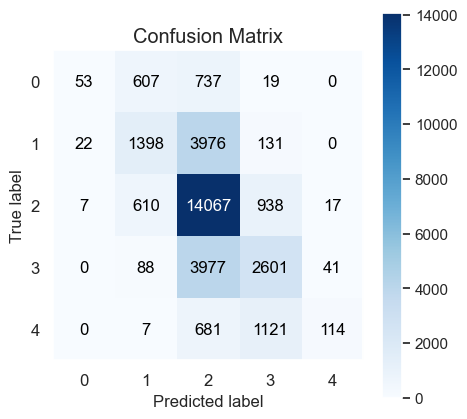

In [263]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(5,5)})
skplt.metrics.plot_confusion_matrix(y_test_2, y_pred)   

In [264]:
print(classification_report(y_test_2, y_pred, target_names=['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive']))

                   precision    recall  f1-score   support

         negative       0.65      0.04      0.07      1416
somewhat negative       0.52      0.25      0.34      5527
          neutral       0.60      0.90      0.72     15639
somewhat positive       0.54      0.39      0.45      6707
         positive       0.66      0.06      0.11      1923

         accuracy                           0.58     31212
        macro avg       0.59      0.33      0.34     31212
     weighted avg       0.58      0.58      0.53     31212



### Model 2.1 -- CNB on uncleaned data (full reviews)

In [245]:
# create instance of CNB classifier
cnb = ComplementNB()

# Fit the classifier on the training data
cnb.fit(X_train_vectors_1, y_train_1)

# Make predictions on the test data
y_pred_1 = cnb.predict(X_test_vectors_1)

accuracy = metrics.accuracy_score(y_test_1, y_pred_1)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.39


In [247]:
# vectorize test data
test_vectors_1 = vectorizer.transform(test_df_1['Phrase'])
# run on test data
y_pred_final = cnb.predict(test_vectors_1)
# append predictions to DF
test_df_1['predictions'] = y_pred_final
test_df_1

,PhraseId,SentenceId,Phrase,predictions
0,156061,8545,An intermittently pleasing but mostly routine ...,3
15,156076,8546,Kidman is really the only thing that 's worth ...,3
93,156154,8547,Once you get into its rhythm ... the movie bec...,1
117,156178,8548,I kept wishing I was watching a documentary ab...,2
158,156219,8549,"Kinnear does n't aim for our sympathy , but ra...",4
...,...,...,...,...
66220,222281,11851,Not sweet enough to liven up its predictable s...,1
66239,222300,11852,"Nasty , ugly , pointless and depressing , even...",0
66253,222314,11853,"With tightly organized efficiency , numerous f...",3
66280,222341,11854,They should have called it Gutterball .,1


### Model 2.2 -- CNB on uncleaned data (all phrases)

In [265]:
cnb = ComplementNB()
# Fit the classifier on the training data
cnb.fit(X_train_vectors_2, y_train_2)
# Make predictions on the test data
y_pred = cnb.predict(X_test_vectors_2)
accuracy = metrics.accuracy_score(y_test_2, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.52


In [266]:
# vectorize test data
test_vectors_2 = vectorizer.transform(test_df_2['Phrase'])
# run on test data
y_pred_final = cnb.predict(test_vectors_2)
# append predictions to DF
test_df_2['predictions'] = y_pred_final
test_df_2

,PhraseId,SentenceId,Phrase,predictions
0,156061,8545,An intermittently pleasing but mostly routine ...,3
1,156062,8545,An intermittently pleasing but mostly routine ...,3
2,156063,8545,An,3
3,156064,8545,intermittently pleasing but mostly routine effort,3
4,156065,8545,intermittently pleasing but mostly routine,3
...,...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario .",1
66288,222349,11855,"A long-winded , predictable scenario",1
66289,222350,11855,"A long-winded ,",1
66290,222351,11855,A long-winded,1


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

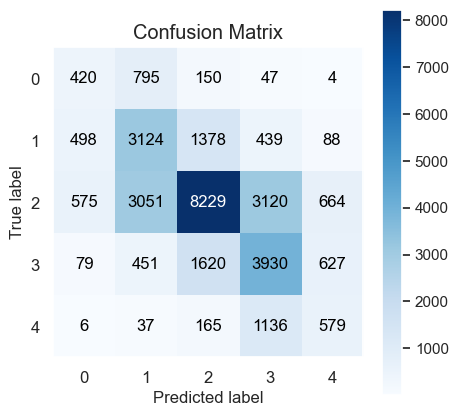

In [267]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(5,5)})
skplt.metrics.plot_confusion_matrix(y_test_2, y_pred)   

In [268]:
print(classification_report(y_test_2, y_pred, target_names=['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive']))

                   precision    recall  f1-score   support

         negative       0.27      0.30      0.28      1416
somewhat negative       0.42      0.57      0.48      5527
          neutral       0.71      0.53      0.61     15639
somewhat positive       0.45      0.59      0.51      6707
         positive       0.30      0.30      0.30      1923

         accuracy                           0.52     31212
        macro avg       0.43      0.46      0.44     31212
     weighted avg       0.56      0.52      0.53     31212



## Section 5: Model Evaluation

Evaluate performance of the model. Consider the following: accuracy, precision, recall, f1-score, confusion matrix, classification report, etc.

### Model 1

In [145]:
# count misclassified reviews
misclassified = np.where(y_pred != y_test)[0]
print('Misclassified tweets:', len(misclassified))

Misclassified tweets: 1020


In [148]:
## create a dataframe to store the misclassified tweets
misclassified_df = pd.DataFrame({'text': X_test.iloc[misclassified], 'actual': y_test.iloc[misclassified], 'predicted': y_pred[misclassified]})
misclassified_df

,text,actual,predicted
147846,dark bittersweet twist feel strange thing turn...,2,3
147567,hard predict absolutely essential chemistry ea...,4,3
114047,yet actress quite singer,2,1
123622,dong show intolerance power deform family tear...,2,3
96599,director paul cox unorthodox abstract approach...,3,1
...,...,...,...
46572,muccino seem explore idea human long get trouble,3,1
70992,ensemble cast turn collectively stellar perfor...,4,3
133874,movie impressed solemn insight work much enter...,1,3
64440,picture maik firebrand turn savvy ad man would...,2,3


In [147]:
# Calculate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.40


In [152]:
!pip install scikit-plot

<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

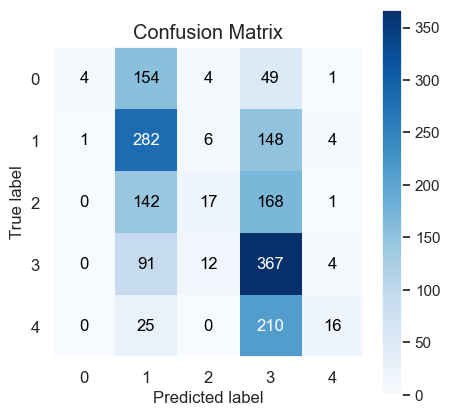

In [156]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(5,5)})
skplt.metrics.plot_confusion_matrix(y_test, y_pred)      

In [158]:
print(classification_report(y_test, y_pred, target_names=['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive']))

                   precision    recall  f1-score   support

         negative       0.80      0.02      0.04       212
somewhat negative       0.41      0.64      0.50       441
          neutral       0.44      0.05      0.09       328
somewhat positive       0.39      0.77      0.52       474
         positive       0.62      0.06      0.12       251

         accuracy                           0.40      1706
        macro avg       0.53      0.31      0.25      1706
     weighted avg       0.49      0.40      0.31      1706



### Model 2

In [284]:
# output some of the misclassified tweets
misclassified = np.where(y_pred_1 != y_test)[0]
print('Misclassified tweets:', len(misclassified))

## create a dataframe to store the misclassified tweets
misclassified_df = pd.DataFrame({'text': X_test.iloc[misclassified], 'actual': y_test.iloc[misclassified], 'predicted': y_pred_1[misclassified]})
misclassified_df

Misclassified tweets: 1055


,text,actual,predicted
50817,like tarantino movie heart alias betty richly ...,3,4
147846,dark bittersweet twist feel strange thing turn...,2,3
147567,hard predict absolutely essential chemistry ea...,4,1
114047,yet actress quite singer,2,4
123622,dong show intolerance power deform family tear...,2,3
...,...,...,...
79217,plot character drama emotion idea irrelevant e...,1,3
46572,muccino seem explore idea human long get trouble,3,1
133874,movie impressed solemn insight work much enter...,1,3
64440,picture maik firebrand turn savvy ad man would...,2,3


In [293]:
# Calculate the accuracy of the classifier
accuracy = metrics.accuracy_score(y_test, y_pred_1)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.38


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

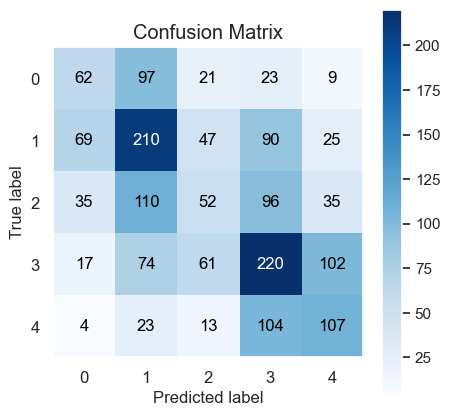

In [294]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(5,5)})
skplt.metrics.plot_confusion_matrix(y_test, y_pred_1)   

In [295]:
print(classification_report(y_test, y_pred_1, target_names=['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive']))

                   precision    recall  f1-score   support

         negative       0.33      0.29      0.31       212
somewhat negative       0.41      0.48      0.44       441
          neutral       0.27      0.16      0.20       328
somewhat positive       0.41      0.46      0.44       474
         positive       0.38      0.43      0.40       251

         accuracy                           0.38      1706
        macro avg       0.36      0.36      0.36      1706
     weighted avg       0.37      0.38      0.37      1706



## Section 6: Summary
    

In [298]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

Comparing performance of Multinomial Naive Bayes on full reviews with Complement Naive Bayes on full reviews, featurized with the Tf-idf Vectorizer. 

Process: 
1. Subset train and test dataframes to obtain full reviews only
2. Vectorize train dataframe
3. Train, test, split train set for a validation set
4. Fit model
5. Vectorize and fit test set
6. Calculate accuracy score, confusion matrix, and classification report for each model

After creating my initial models which I will compare here, I wanted to do some more testing to see how the unprocessed, complete dataset would perform with MNB and CNB. The model that I trained with MNB on the full, uncleaned training set achieved the highest accuracy score of all of my models. With further testing, I would compare the results of the aforementioned model with a version that is performed on the full, cleaned data. I forewent this additional step because of long runtime for the preprocessing operation. 

Comparing my original two models, I noticed that my initial assumption about CNB was wrong. Despite the unequal distribution of sentiments -- with class 2 (neutral) reviews being most represented in the dataset -- CNB performed worse on overall accuracy than MNB. However, CNB outperformed MNB on other metrics. 

| model      | accuracy score | # misclassified  | 
| :- |------------- | :-------------|
| MNB      | 0.40      | 1020 |
| CNB   | 0.38        | 1055 |

When comparing the confusion matrices of the two models, I noticed that the distribution of misclassified reviews was markedly different. MNB had higher precision scores across the board and best performed with negative reviews. Its precision struggled in the "somewhat" categories. However, "somewhat neg" and "somewhat pos" had the highest precision scores, indicating that the model correctly predicted those labels at a higher rate when compared to the reviews' true labels. MNB had high F1 scores ~0.5 for somewhat negative and somewhat positive reviews and struggled in all other classes.

In contrast, model 2 had more evenly distributed precision and recall scores. Its F1 scores ranged from 0.3-0.45, which suggests that CNB was able to [normalize](https://scikit-learn.org/stable/modules/naive_bayes.html#complement-naive-bayes) the imbalanced dataset. CNB matched, if not slightly exceeded, the performance in classifying "somewhat" labels compared to MNB. By viewing the confusion matrix, we can gather that it made more mistakes in distinguishing "negative" from "slightly negative" and "positive" from "slightly positive." However, unlike MNB, it did not misclass some of these reviews as "neutral" or confidently misprefer the "somewhat" labels. By this metric, as seen in the higher F1 scores, CNB performed better. 

Of course, both models are constrained by the limits of Naive Bayes constructions and Tf-idf vectorization. Recall that NB introduces bias through its assumption that the presence of one word is independent of the presence of any other word in a document. This restricts our ability to understand language in our corpus contextually, which diverges from our assumptions about how humans communicate information. For instance, the presence of a specific sequence of words before or after a word in a phrase may suggest sarcasm or humor; NB would likely struggle to classify such phrases. 

For the purposes of intial classification, NB remains a reliable option for its computational speed. It also has the advantage of interpretability, which is lost in neural nets/deep learning algorithms. 